In [1]:
import boto3
import pandas as pd
from hatchet_sdk import new_client
from pydantic import AnyUrl

from epengine.models.shoebox import ShoeboxSimulationSpec

exp_id = "test-w-multi-step-2"
spec = ShoeboxSimulationSpec(
    experiment_id=exp_id,
    sort_index=0,
    lib_uri=AnyUrl("s3://ml-for-bem/tiles/massachusetts/2024_09_30/everett_lib.json"),
    typology="Residential",
    year_built=1972,
    num_floors=3,
    neighbor_polys=["POLYGON ((-10 0, -10 10, -5 10, -5 0, -10 0))"],
    neighbor_floors=[3],
    rotated_rectangle="POLYGON ((5 0, 5 10, 15 10, 15 0, 5 0))",
    long_edge=10,
    short_edge=10,
    long_edge_angle=0.23,
    footprint_area=100,
    epwzip_path="https://climate.onebuilding.org/WMO_Region_4_North_and_Central_America/USA_United_States_of_America/MA_Massachusetts/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2009-2023.zip",
)
specs = []
n = 10
for i in range(n):
    spec.long_edge = (i / (n - 1)) * 20 + 10
    spec.sort_index = i
    specs.append(spec.model_dump(mode="json"))
# specs = [spec.model_dump(mode="json")] * 100
df = pd.DataFrame(specs)
df.to_parquet("shoebox_specs.parquet")
s3 = boto3.client("s3")
key = f"hatchet/{exp_id}/shoebox_specs.parquet"
s3.upload_file("shoebox_specs.parquet", "ml-for-bem", key)
uri = f"s3://ml-for-bem/{key}"

In [3]:
client = new_client()

payload = {
    "workflow_name": "simulate_ubem_shoebox",
    "experiment_id": exp_id,
    "bucket": "ml-for-bem",
    "specs": uri,
    # "recursion_map": {"factor": 3, "max_depth": 1},
}
# client.admin.run_workflow("scatter_gather_recursive", payload)
client.admin.run_workflow("scatter_gather", payload)

In [8]:
from hatchet_sdk import new_client

client = new_client()
# l = client.rest.workflow_run_list("515001b6-84cf-42a7-a750-bb33398676b8",limit=100)
l = client.rest.workflow_run_list(
    "cbb1176f-96b7-415a-8867-43b5ba1cc605", limit=100, offset=1
)
l

WorkflowRunList(rows=[], pagination=PaginationResponse(current_page=2, next_page=3, num_pages=100))

In [28]:
key = "hatchet/test-splitter-w-lengths-4/specs/90188da0-f4df-4302-9a4b-8684425aed93/90188da0-f4df-4302-9a4b-8684425aed93_specs_000000.pq"
s3.download_file("ml-for-bem", key, "shoebox_specs.parquet")
df = pd.read_parquet("shoebox_specs.parquet")
len(df)

11

100

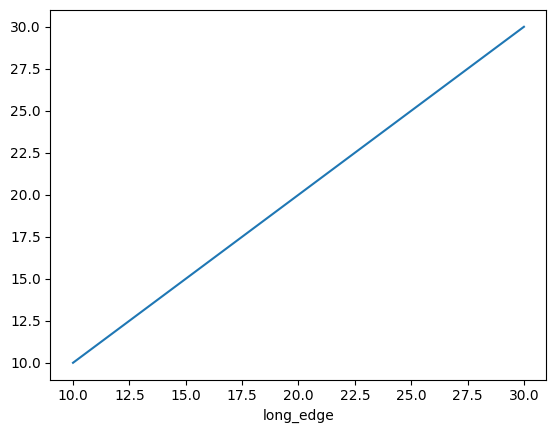

In [26]:
key = "hatchet/test-splitter-w-lengths-4/results/root/9b37227e-4ac0-4f2d-bce0-6a24d478e563.h5"
s3.download_file("ml-for-bem", key, "shoebox_results.h5")
df = pd.read_hdf("shoebox_results.h5")
df.sort_index(level="sort_index").index.get_level_values("long_edge").to_series().plot()